1. Gerekli kütüphaneler

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, roc_curve, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, ELU, ReLU, LeakyReLU
from tensorflow.keras.optimizers import AdamW, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from collections import Counter
from imblearn.over_sampling import SMOTE
import joblib

2. Veriyi okuma

In [30]:
# Verileri oku
train_df = pd.read_csv("../datasets/normal/train_mental.csv")
test_df = pd.read_csv("../datasets/normal/test_mental.csv")

# Özellik ve hedef ayır
X_train = train_df.drop("support_needed", axis=1)
y_train = train_df["support_needed"]

X_test = test_df.drop("support_needed", axis=1)
y_test = test_df["support_needed"]

# (Opsiyonel olarak y_train_cat ve y_test_cat tanımlanabilir ama gerek yok)

print("✅ Eğitim verisi:", X_train.shape)
print("✅ Test verisi:", X_test.shape)
print("🎯 Sınıf dağılımı (y_train):\n", y_train.value_counts())

✅ Eğitim verisi: (1007, 23)
✅ Test verisi: (252, 23)
🎯 Sınıf dağılımı (y_train):
 support_needed
0    528
1    479
Name: count, dtype: int64


3. SMOTE ile veri dengeleme

In [31]:
# 🎯 Orijinal sınıf dağılımı
print("🎯 Orijinal sınıf dağılımı:", Counter(y_train))

# 🌟 1️⃣ SMOTE ile oversampling (dengesiz sınıfı dengeleme)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# 🎯 Dengelenmiş sınıf dağılımını kontrol etme
print("⚖️ Dengelenmiş eğitim sınıf dağılımı:", Counter(y_train_balanced))

🎯 Orijinal sınıf dağılımı: Counter({0: 528, 1: 479})
⚖️ Dengelenmiş eğitim sınıf dağılımı: Counter({0: 528, 1: 528})


In [32]:
# # 🌟 1️⃣ Scaler'ı yükle (preprocess aşamasında oluşturduğumuz)
# scaler = joblib.load("../deployment/mental_scalers.pkl")
# print("✅ Scaler yüklendi: '../deployment/mental_scaler.pkl'")

# # Eğitim verisini ölçekleme
# X_train_scaled = scaler.transform(X_train)

# # Test verisini aynı scaler ile ölçekleme
# X_test_scaled = scaler.transform(X_test)

# # 🌟 2️⃣ SMOTE ile oversampling (dengesiz sınıfı dengeleme)
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# # 🎯 Dengelenmiş sınıf dağılımını kontrol etme
# print("⚖️ Dengelenmiş eğitim sınıf dağılımı:", Counter(y_train_balanced))

4. Model Tanımı

In [33]:
def build_ann_model():
    model = Sequential([
        Input(shape=(X_train_balanced.shape[1],)),

        # # 1. Katman
        Dense(256),
        ELU(),  
        BatchNormalization(),
        Dropout(0.4),

        # 2. Katman
        Dense(128),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.3),

        # 3. Katman
        Dense(64),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.2),

        # 3. Katman
        Dense(32),
        ReLU(),
        BatchNormalization(),
        Dropout(0.2),

        # 4. Katman
        Dense(16),
        ReLU(),
        Dropout(0.1),

        # Çıkış Katmanı
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss=BinaryCrossentropy(),
        optimizer=AdamW(learning_rate=0.005, weight_decay=0.0001),
        metrics=['accuracy']
    )
    return model

# 🌟 Modeli oluşturma
model = build_ann_model()

model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_5 (ELU)                     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,841 (202.50 KB)

 Trainable params: 50,881 (198.75 KB)

 Non-trainable params: 960 (3.75 KB)

5. Model eğitimi

In [34]:
# 🌟 Eğitim verisini DataFrame'e dönüştürme
X_train_scaled = pd.DataFrame(X_train_balanced, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test, columns=X_test.columns)

# Early stopping ve öğrenme oranı azaltma
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-6)

# Sınıf ağırlıkları (Dengeli)
class_weights = dict(enumerate(compute_class_weight(class_weight='balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)))

# 🌟 Model eğitimi
history = model.fit(
    X_train_scaled,
    y_train_balanced,
    class_weight=class_weights,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop, reduce_lr]  
)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5606 - loss: 0.8161 - val_accuracy: 0.4575 - val_loss: 2.9842 - learning_rate: 0.0050
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6448 - loss: 0.6637 - val_accuracy: 0.4481 - val_loss: 1.9347 - learning_rate: 0.0050
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7083 - loss: 0.5747 - val_accuracy: 0.8066 - val_loss: 0.4528 - learning_rate: 0.0050
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7498 - loss: 0.4814 - val_accuracy: 0.5802 - val_loss: 1.0497 - learning_rate: 0.0050
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7696 - loss: 0.4992 - val_accuracy: 0.8066 - val_loss: 0.4813 - learning_rate: 0.0050
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7911 - loss: 0.4625 - val_accuracy: 0.7925 - val_loss: 0.4377 - learning_rate: 0.0050
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7748 - loss: 0.4900 - 

6. Tahmin ve değerlendirme

In [35]:
def find_optimal_threshold(y_true, y_prob):
    """
    En iyi eşik değerini bulur.
    """
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_prob)

    # Youden's J İstatistiği ile en iyi threshold
    j_scores = tpr - fpr
    optimal_threshold_j = thresholds_roc[np.argmax(j_scores)]
    print(f"🔍 En iyi threshold (Youden's J): {optimal_threshold_j:.4f}")

    # F1 skoru ile en iyi threshold
    f1_scores = [f1_score(y_true, (y_prob >= t).astype(int)) for t in thresholds_pr]
    optimal_threshold_f1 = thresholds_pr[np.argmax(f1_scores)]
    print(f"🔍 En iyi threshold (F1 skoru): {optimal_threshold_f1:.4f}")

    return optimal_threshold_j, optimal_threshold_f1

# Modelden olasılık tahminleri al
y_prob = model.predict(X_test).flatten()

# En iyi threshold değerini bul
optimal_threshold_j, optimal_threshold_f1 = find_optimal_threshold(y_test, y_prob)

# Deploy için en uygun threshold
optimal_threshold = optimal_threshold_f1
print(f"🌟 Model için belirlenen optimal threshold: {optimal_threshold:.4f}")

# 🌟 Threshold'u dosyaya kaydetme
try:
    with open("optimal_threshold.txt", "w") as f:
        f.write(str(optimal_threshold))
    print("✅ Optimal threshold başarıyla kaydedildi.")
except Exception as e:
    print(f"❌ Threshold kaydedilemedi: {str(e)}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
🔍 En iyi threshold (Youden's J): 0.5833
🔍 En iyi threshold (F1 skoru): 0.5833
🌟 Model için belirlenen optimal threshold: 0.5833
✅ Optimal threshold başarıyla kaydedildi.


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       132
           1       0.90      0.93      0.92       120

    accuracy                           0.92       252
   macro avg       0.92      0.92      0.92       252
weighted avg       0.92      0.92      0.92       252



/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


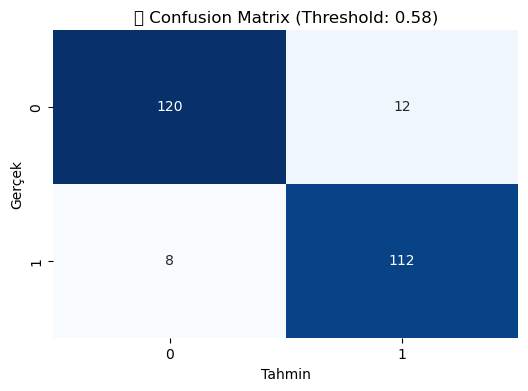

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


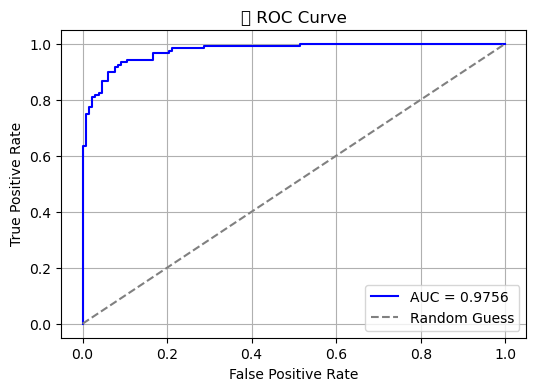

In [36]:
# 🌟 Optimal threshold ile sınıf tahmini
y_pred = (y_prob >= optimal_threshold).astype("int32")

# 📋 Sınıflandırma Raporu
print("📋 Classification Report:\n", classification_report(y_test, y_pred))

# 📊 Confusion Matrix Görselleştirme
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"📌 Confusion Matrix (Threshold: {optimal_threshold:.2f})")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()

# 🌈 ROC Eğrisi ve AUC Hesaplama
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("🌟 ROC Curve")
plt.grid(True)
plt.show()

7. Deployment

In [39]:
# 📦 Modeli kaydet (sadece ANN modeli)
# model.save("../deployment/mental_ann_model.keras")
# joblib.dump(model, "../deployment/mental_ann_model.pkl")

print("💾 Model ve scaler başarıyla kaydedildi:")
print("- mental_ann_model.keras")
print("- mental_ann_model.pkl")

💾 Model ve scaler başarıyla kaydedildi:
- mental_ann_model.keras
- mental_ann_model.pkl


8. Özellik önemi

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


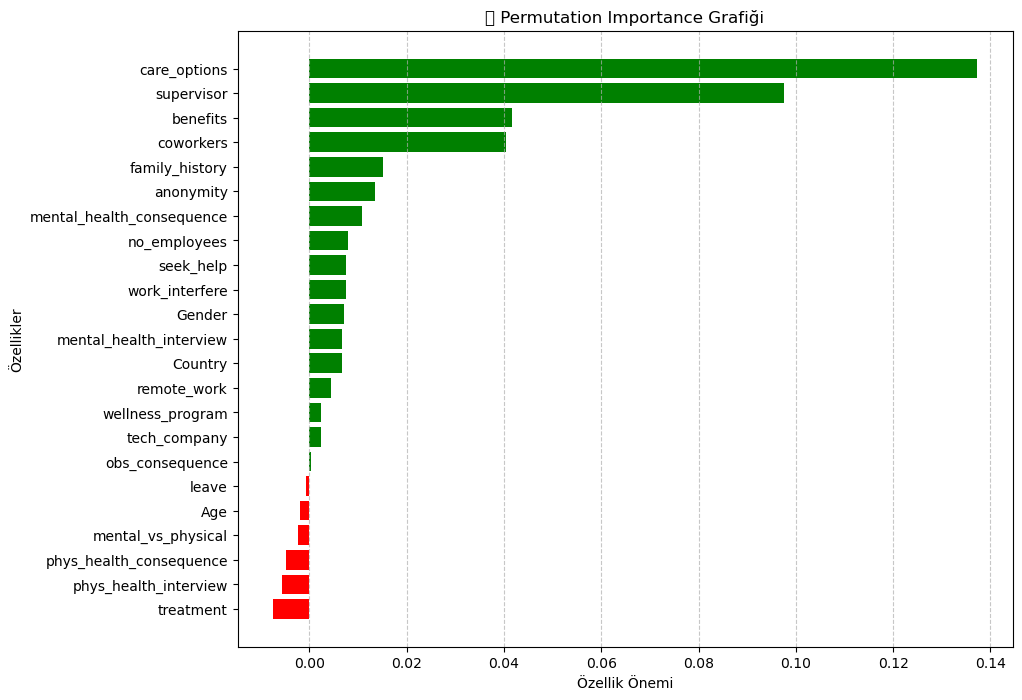

In [49]:
from scikeras.wrappers import KerasClassifier
from sklearn.inspection import permutation_importance

# 📊 Sonuçları DataFrame olarak saklama
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# 🌈 Grafik oluşturma
plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in importance_df['Importance']]
plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.xlabel('Özellik Önemi')
plt.ylabel('Özellikler')
plt.title('🔍 Permutation Importance Grafiği')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()